<a href="https://colab.research.google.com/github/Falconwatch/SexInRussiaStudy/blob/main/SexInRussia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачивание данных и импорты

In [1]:
!wget https://github.com/Falconwatch/SexInRussiaStudy/raw/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx

--2021-10-26 13:08:02--  https://github.com/Falconwatch/SexInRussiaStudy/raw/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Falconwatch/SexInRussiaStudy/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx [following]
--2021-10-26 13:08:02--  https://raw.githubusercontent.com/Falconwatch/SexInRussiaStudy/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx
Resolving raw.githubusercontent

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Чтение данных и предобработка

In [3]:
data = pd.read_excel("Россия_в_постели_открытые_данные.xlsx", skiprows=2)

In [4]:
data.loc[~data["Пол"].isin(["Женский", "Мужской"]), "Пол"] = "Иное"

# Основные статистики

## Гендерный состав

Женский    23249
Мужской    10011
Иное         363
Name: Пол, dtype: int64

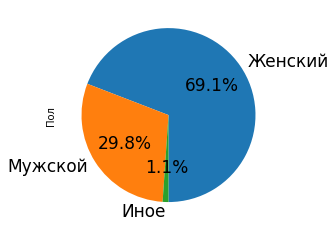

In [5]:
gender_stats = data["Пол"].value_counts()
total_women = gender_stats["Женский"]
total_men = gender_stats["Мужской"]

gender_stats.plot(kind="pie", autopct='%1.1f%%', startangle=270, fontsize=17)
gender_stats

## Возрастной состав

In [6]:
gender_age_stats = data.groupby(["Пол", "Возраст"])["Пол"].count()
gender_age_stats

Пол      Возраст    
Женский  18-24          18276
         25-34           4404
         35-44            474
         45-54             77
         55 и старше        5
Иное     18-24            264
         25-34             63
         35-44             10
         45-54              3
         55 и старше        7
Мужской  18-24           5037
         25-34           3803
         35-44            960
         45-54            173
         55 и старше       32
Name: Пол, dtype: int64

In [7]:
gender_age_stats.unstack()

Возраст,18-24,25-34,35-44,45-54,55 и старше
Пол,,,,,
Женский,18276,4404,474,77,5
Иное,264,63,10,3,7
Мужской,5037,3803,960,173,32


## Начало половой жизни

In [8]:
data["Возраст первого секса"].value_counts()

18               5505
17               5447
16               5439
15               3198
19               2937
Не было секса    2901
14               1910
20               1691
21               1141
Позже 23          704
13                683
22                587
Раньше 13         453
23                405
Name: Возраст первого секса, dtype: int64

# Предобработка предпочтений и практик

In [9]:
#Список предпочтений
preferences = np.concatenate(data["Сексуальные предпочтения"].apply(lambda x: str(x).split(",")))
preferences = np.array([p.lstrip().rstrip() for p in preferences])

#Чиним баг со сквиртингом
preferences[preferences=="Сквитринг"] = "Сквиртинг"

#Считаем уникальные предпочтения и кладём в датафрейм
unique_values, unique_counts = np.unique(preferences, return_counts=True)
preferences_dataframe = pd.DataFrame(data = unique_values, columns = ["Предпочтение"])

preferences_dataframe["counts"] = unique_counts
preferences_dataframe.sort_values("counts", ascending=False, inplace=True)
preferences_dataframe.reset_index(inplace=True)
preferences_dataframe.drop(["index"], axis=1, inplace=True)

In [10]:
## Выделим самые популярные (или преставленные как варианты выбора)
##Криетрий популярности - более 0.1% человек

In [11]:
popular_preferences = preferences_dataframe[preferences_dataframe["counts"]>data.shape[0]/1000]

In [12]:
def normalize_preferences(prefs):
  result = list()
  prefs_splited = prefs.split(",")
  prefs_splited = [p.lstrip().rstrip() for p in prefs_splited]
  for one_pref in prefs_splited:
    if one_pref in popular_preferences["Предпочтение"].values:
      result.append(one_pref)
    else:
      result.append("Иное")
  result = np.unique(np.sort(np.array(result)))
  return result

In [13]:
data["prefs_array"] = data["Сексуальные предпочтения"].apply(lambda x: normalize_preferences(str(x)))
data["practices_array"] = data["Сексуальные практики"].apply(lambda x: normalize_preferences(str(x)))

In [14]:
#Предпочитаю, но не практикую
data["prefs_but_not_practice"] = data.apply(lambda x: list(set(x["prefs_array"]) - set(x["practices_array"])), axis=1)

#Практикую, но не хочу
data["practice_but_not_pref"] = data.apply(lambda x: list(set(x["practices_array"]) - set(x["prefs_array"])), axis=1)

# Желаю и практикую
data["pref_and_practice"] = data.apply(lambda x: list(set.intersection(set(x["prefs_array"]), set(x["practices_array"]))), axis=1)

# доля реализуемых желаний
data["pref_realisation_share"] = data["pref_and_practice"].apply(len) / data["prefs_array"].apply(len)

# Анализ предпочтений и практик

## Желаю

In [15]:
mlb = MultiLabelBinarizer()
prefs_matrix = pd.DataFrame(data = mlb.fit_transform(data["prefs_array"]), columns = mlb.classes_)
prefs = pd.concat([data, prefs_matrix], axis=1)

### Женщины

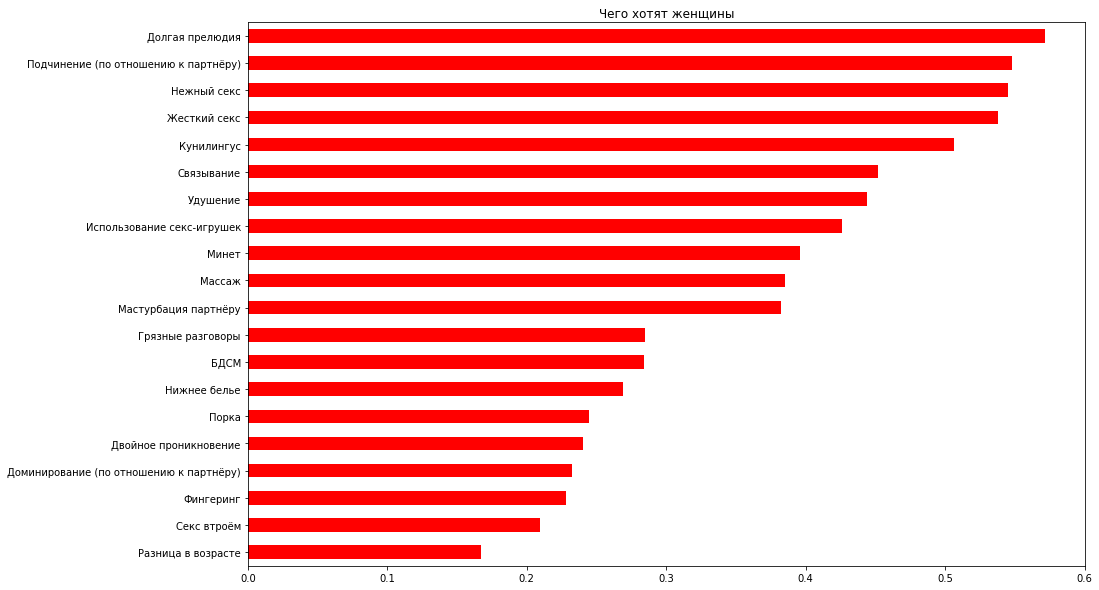

In [16]:
(prefs.loc[prefs["Пол"]=="Женский"][mlb.classes_].sum()/total_women).sort_values()[-20:]\
.plot(kind="barh", title = "Чего хотят женщины", figsize=[15,10], color=["red"])

### Мужчины

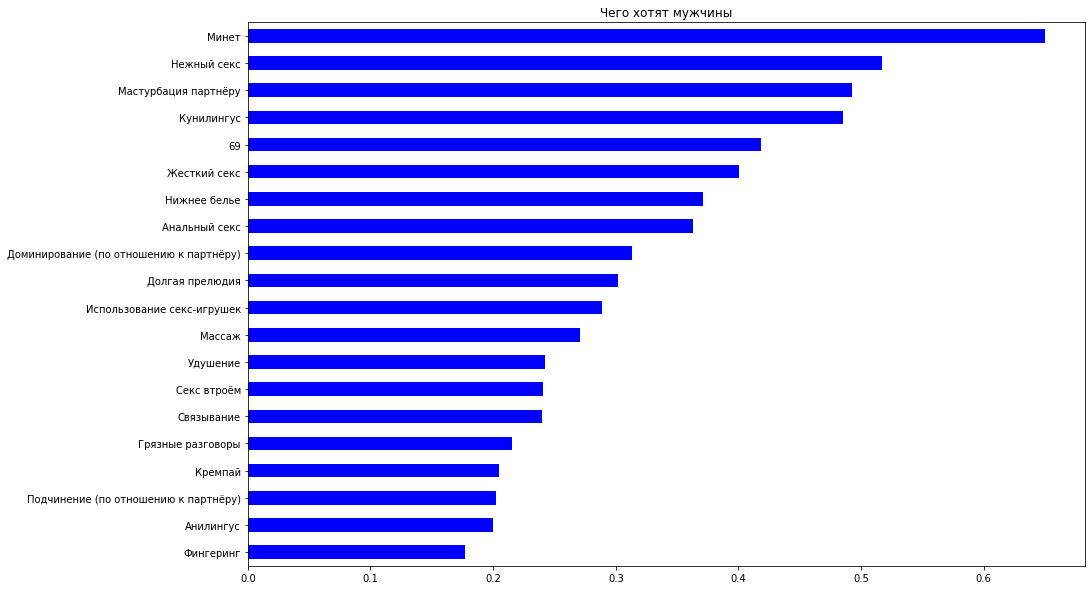

In [17]:
(prefs.loc[prefs["Пол"]=="Мужской"][mlb.classes_].sum()/total_men).sort_values()[-20:]\
.plot(kind="barh", title = "Чего хотят мужчины", figsize=[15,10], color=["blue"])

### Без опыта

In [18]:
newbes_total = prefs.loc[prefs["Возраст первого секса"]=="Не было секса"].shape[0]

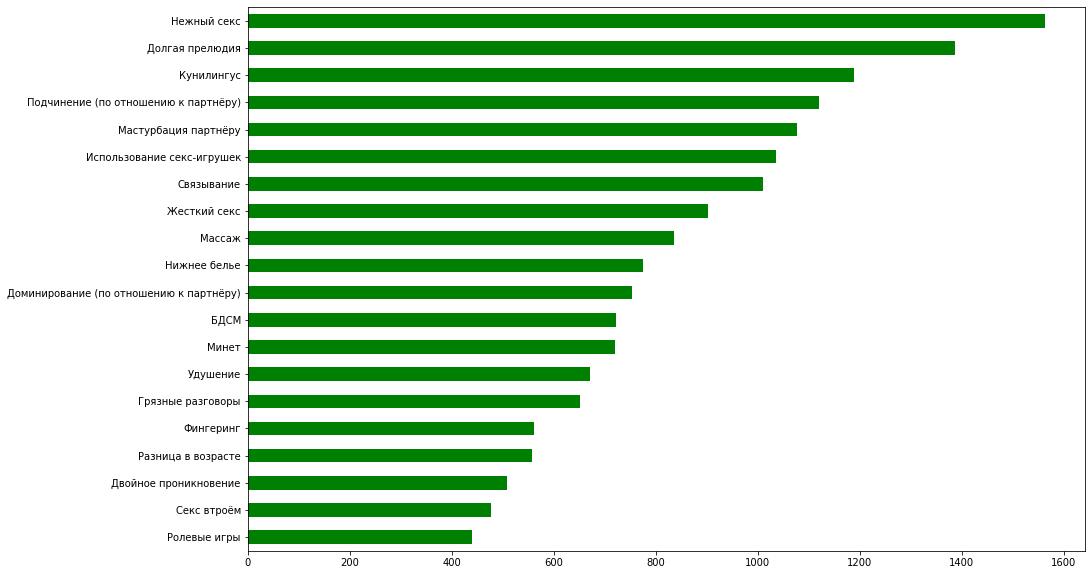

In [19]:
(prefs.loc[prefs["Возраст первого секса"]=="Не было секса"][mlb.classes_].sum()).sort_values()[-20:]\
.plot(kind="barh", color=["green"], figsize=[15,10])

## Желаю и практикую

In [20]:
mlb = MultiLabelBinarizer()
pref_and_practice_matrix = pd.DataFrame(data = mlb.fit_transform(data["pref_and_practice"]), columns = mlb.classes_)
pref_prac = pd.concat([data, pref_and_practice_matrix], axis=1)

### Женщины

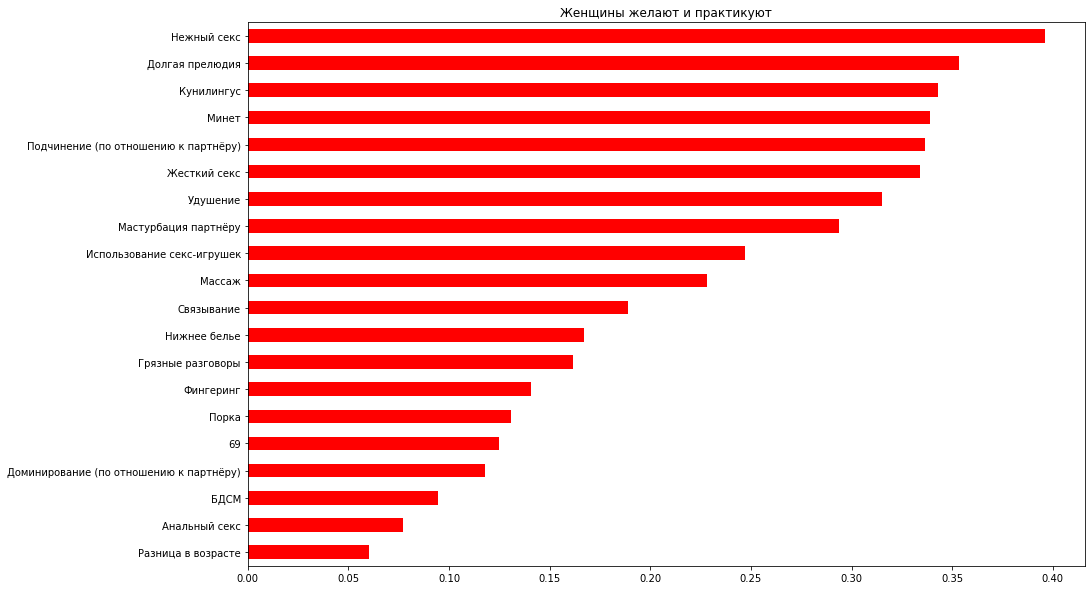

In [21]:
women_pref_prac = pref_prac.loc[pref_prac["Пол"]=="Женский"][mlb.classes_].sum()/total_women
women_pref_prac.sort_values(inplace=True)
women_pref_prac[-20:].plot(kind="barh", figsize=[15,10], title="Женщины желают и практикуют", color=["red"])

### Мужчины

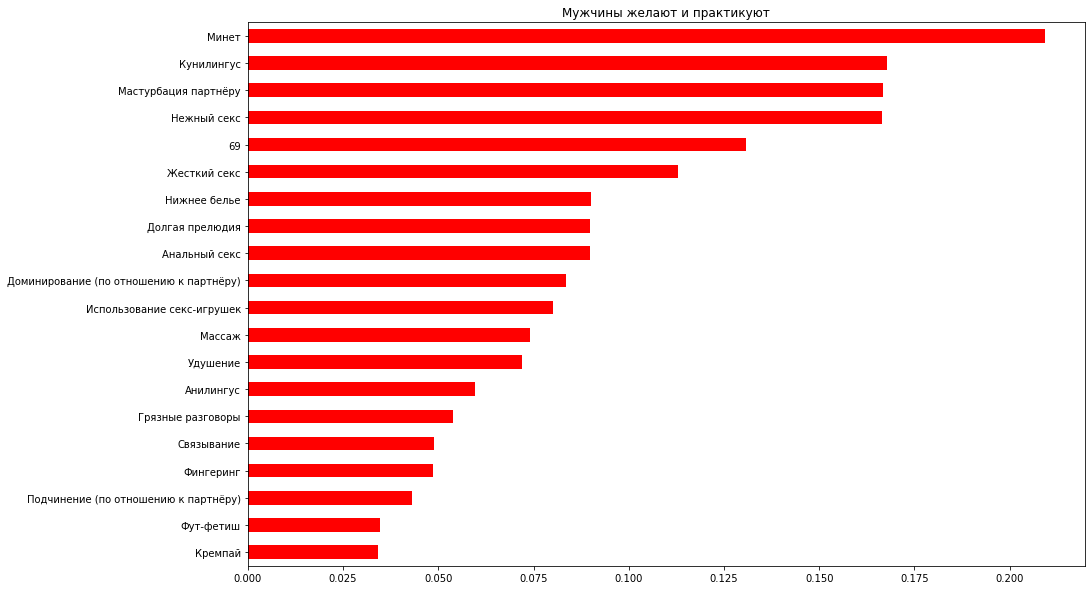

In [22]:
men_pref_prac = pref_prac.loc[pref_prac["Пол"]=="Мужской"][mlb.classes_].sum()/total_women
men_pref_prac.sort_values(inplace=True)
men_pref_prac[-20:].plot(kind="barh", figsize=[15,10], title="Мужчины желают и практикуют", color=["red"])

### Совместно

In [23]:
men_pref_prac.name="men"
women_pref_prac.name="women"

together_pref_prac = pd.merge(left=men_pref_prac, right = women_pref_prac, left_index=True, right_index=True)
together_pref_prac["mean"] = together_pref_prac.mean(axis=1)
together_pref_prac["diff"] = abs(together_pref_prac["men"] - together_pref_prac["women"])

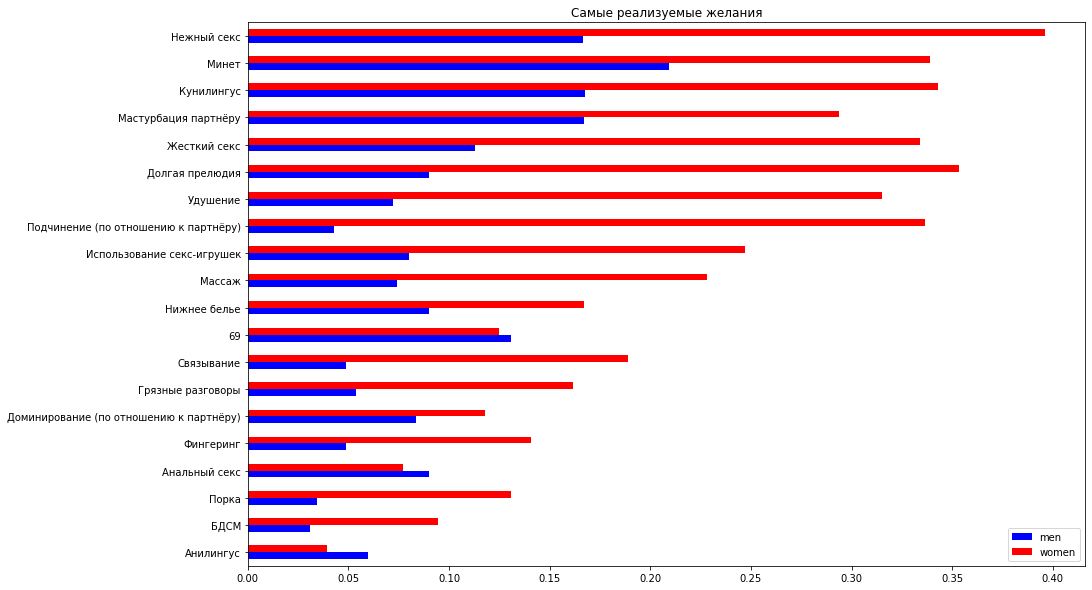

In [24]:
_ = together_pref_prac.sort_values("mean")[["men", "women"]][-20:]\
.plot(kind="barh", figsize=[15,10], title="Самые реализуемые желания",
      color=["blue", "red"])

## Не желаю, но практикую

In [25]:
mlb = MultiLabelBinarizer()
practice_but_not_pref_matrix = pd.DataFrame(data = mlb.fit_transform(data["practice_but_not_pref"]), columns = mlb.classes_)
prac_bnp = pd.concat([data, practice_but_not_pref_matrix], axis=1)

### Женщины

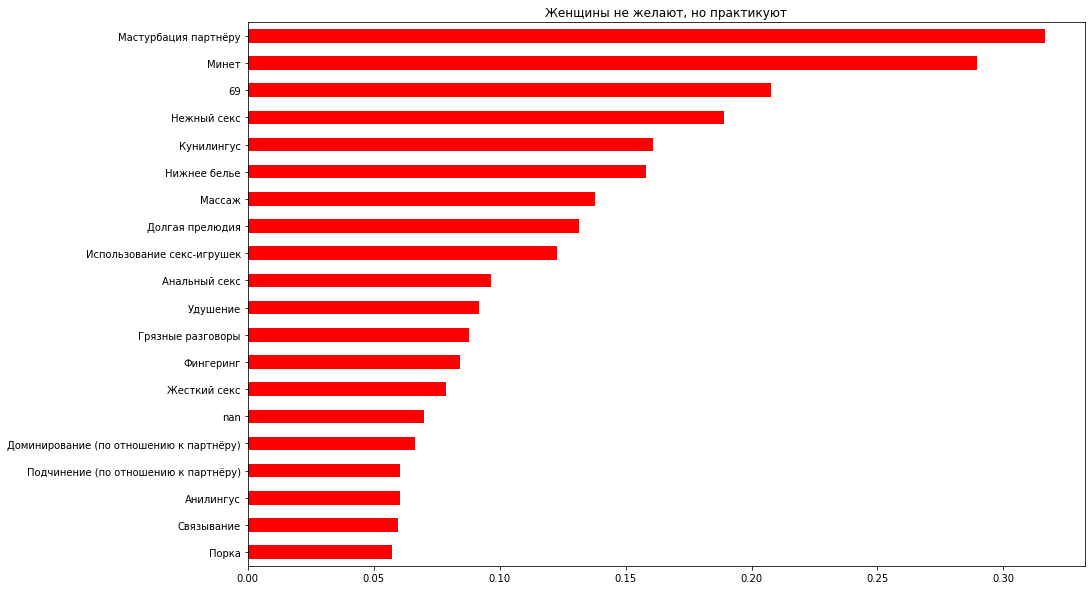

In [26]:
women_prac_bnp = prac_bnp.loc[prac_bnp["Пол"]=="Женский"][mlb.classes_].sum()/total_women
women_prac_bnp.sort_values(inplace=True)
women_prac_bnp[-20:].plot(kind="barh", figsize=[15,10], title="Женщины не желают, но практикуют", color=["red"])

### Мужчины

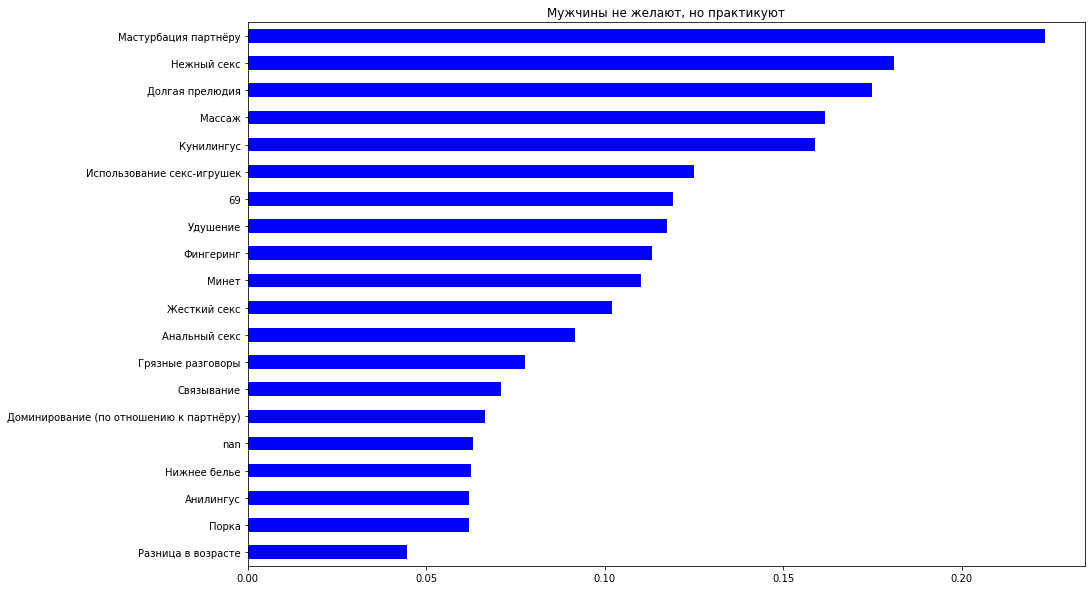

In [27]:
men_prac_bnp = prac_bnp.loc[prac_bnp["Пол"]=="Мужской"][mlb.classes_].sum()/total_men
men_prac_bnp.sort_values(inplace=True)
men_prac_bnp[-20:].plot(kind="barh", figsize=[15,10], title="Мужчины не желают, но практикуют", color=["blue"])

### Совместно

In [28]:
men_prac_bnp.name="men"
women_prac_bnp.name="women"

together_prac_bnp = pd.merge(left=men_prac_bnp, right = women_prac_bnp, left_index=True, right_index=True)
together_prac_bnp["mean"] = together_prac_bnp.mean(axis=1)
together_prac_bnp["diff"] = abs(together_prac_bnp["men"] - together_prac_bnp["women"])

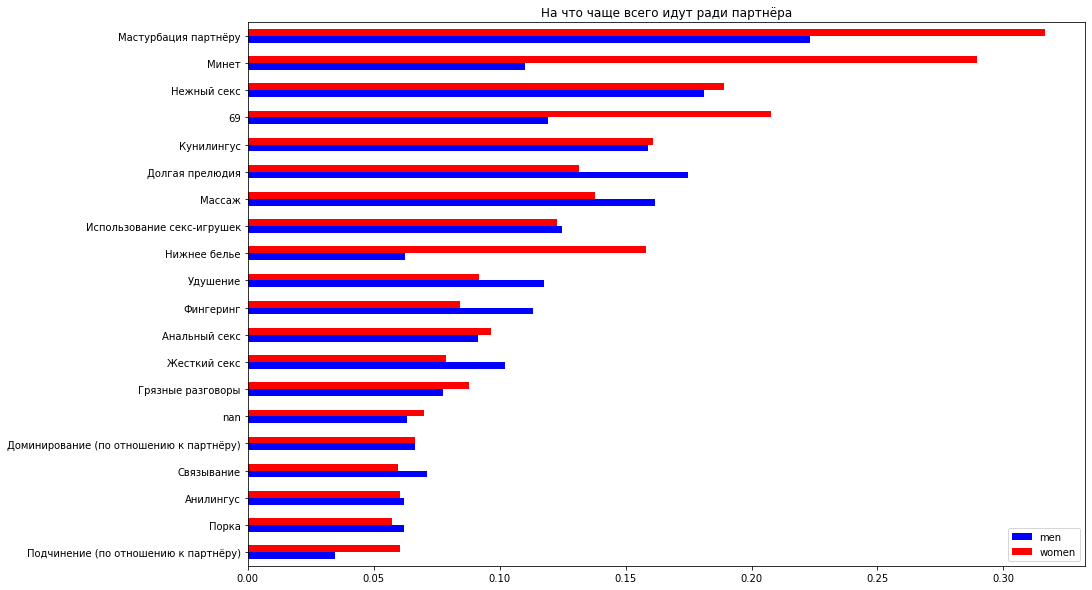

In [29]:
_ = together_prac_bnp.sort_values("mean")[["men", "women"]][-20:]\
.plot(kind="barh", figsize=[15,10], title="На что чаще всего идут ради партнёра",
      color=["blue", "red"])

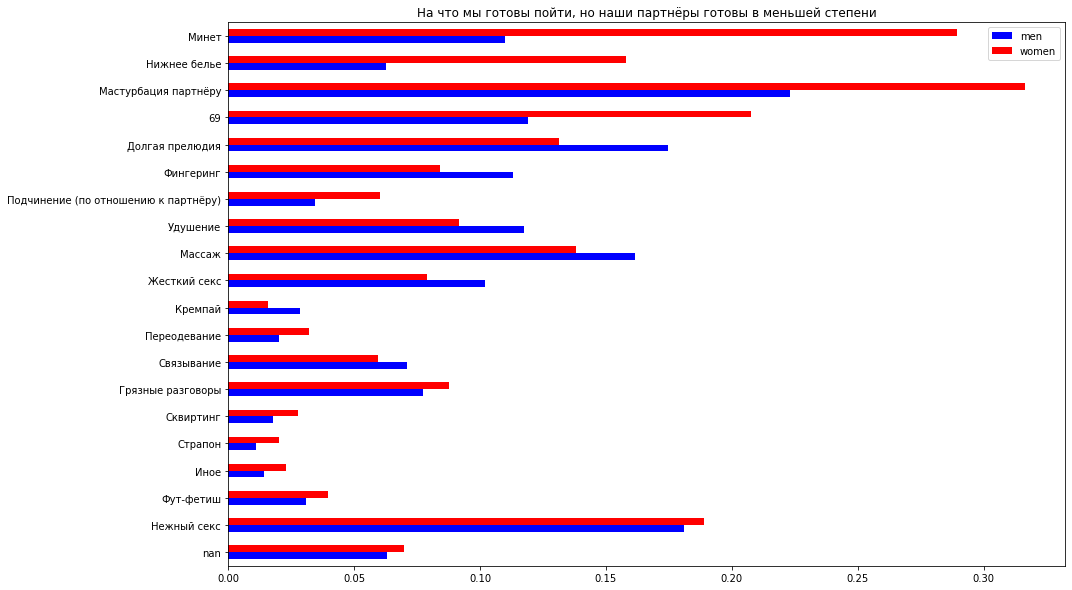

In [30]:
_ = together_prac_bnp.sort_values("diff")[["men", "women"]][-20:]\
.plot(kind="barh", figsize=[15,10], title="На что мы готовы пойти, но наши партнёры готовы в меньшей степени",
      color=["blue", "red"])

## Желаю, но не получаю

In [31]:
mlb = MultiLabelBinarizer()
prefs_but_not_practice_matrix = pd.DataFrame(data = mlb.fit_transform(data["prefs_but_not_practice"]), columns = mlb.classes_)
pref_bnp = pd.concat([data, prefs_but_not_practice_matrix], axis=1)

### Женщины

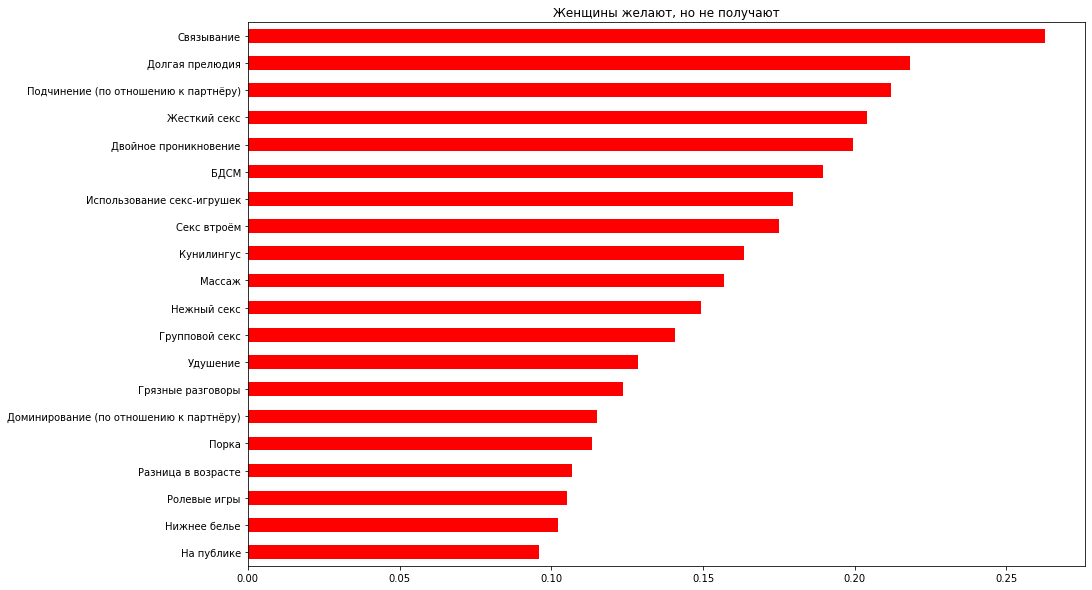

In [32]:
women_pref_bnp = pref_bnp.loc[pref_bnp["Пол"]=="Женский"][mlb.classes_].sum() / total_women
women_pref_bnp.sort_values(inplace=True)
women_pref_bnp[-20:].plot(kind="barh", figsize=[15,10], title="Женщины желают, но не получают", color=["red"])

### Мужчины

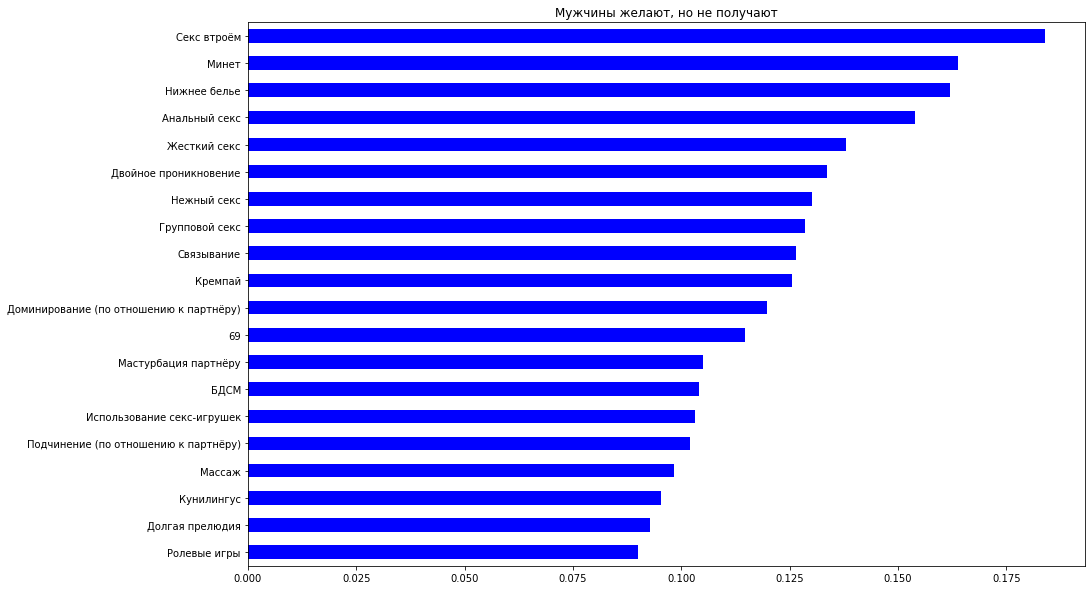

In [33]:
men_pref_bnp = pref_bnp.loc[pref_bnp["Пол"]=="Мужской"][mlb.classes_].sum() / total_men
men_pref_bnp.sort_values(inplace=True)
men_pref_bnp[-20:].plot(kind="barh", figsize=[15,10], title="Мужчины желают, но не получают", color=["blue"])

### Совместно

In [34]:
men_pref_bnp.name="men"
women_pref_bnp.name="women"

together_pref_bnp = pd.merge(left=men_pref_bnp, right = women_pref_bnp, left_index=True, right_index=True)
together_pref_bnp["mean"] = together_pref_bnp.mean(axis=1)
together_pref_bnp["diff"] = abs(together_pref_bnp["men"] - together_pref_bnp["women"])

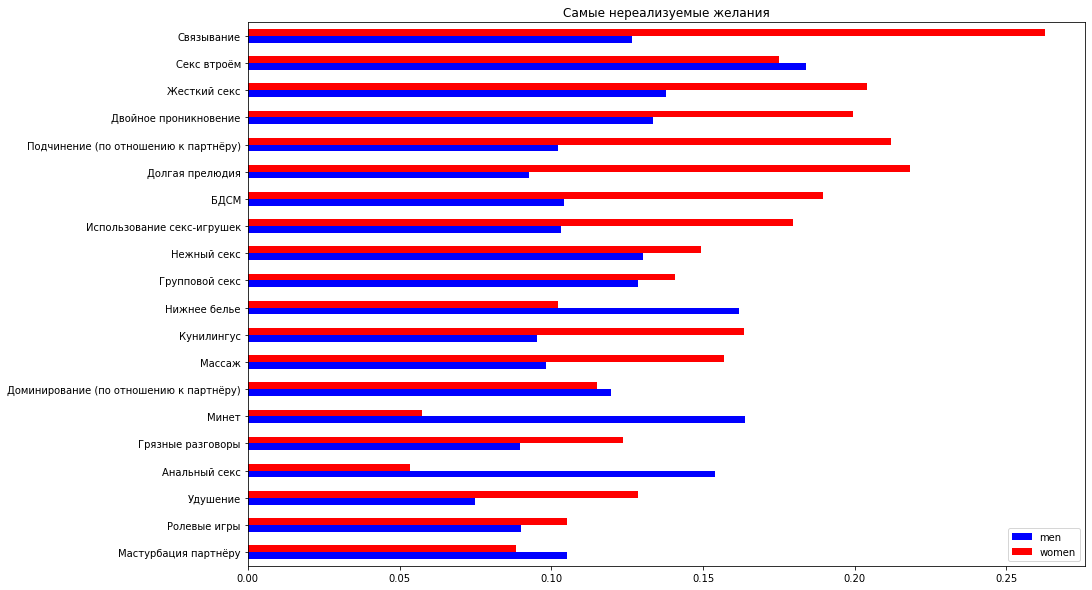

In [35]:
_ = together_pref_bnp.sort_values("mean")[["men", "women"]][-20:]\
.plot(kind="barh", figsize=[15,10], title="Самые нереализуемые желания", 
      color=["blue", "red"])

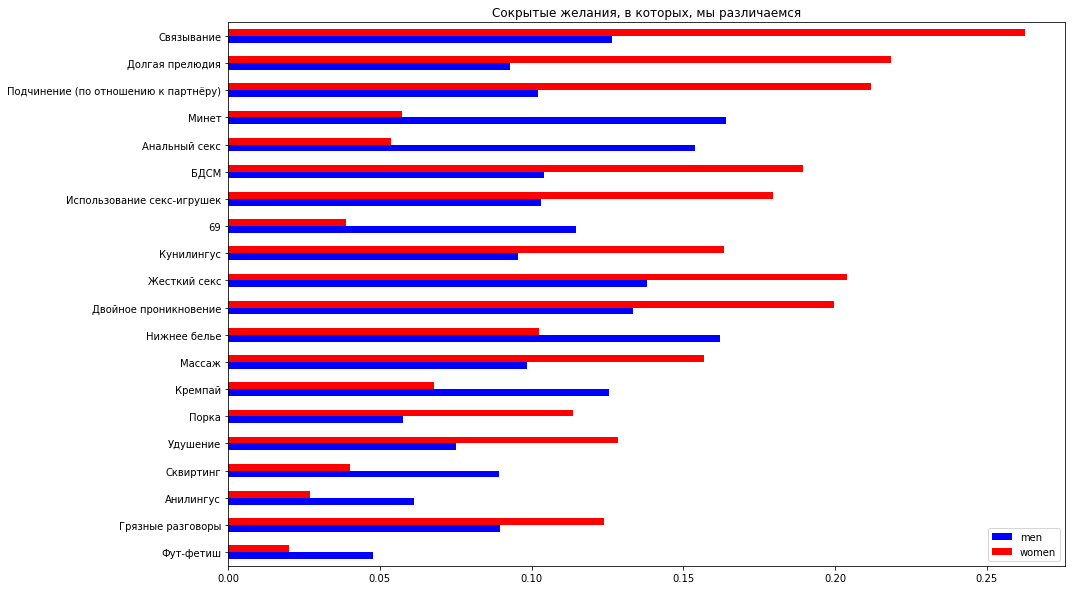

In [36]:
_ = together_pref_bnp.sort_values("diff")[["men", "women"]][-20:]\
.plot(kind="barh", figsize=[15,10], title="Сокрытые желания, в которых, мы различаемся",
      color=["blue", "red"])

## Насколько легко реализовать свои желания

In [37]:
print("В среднем:", data["pref_realisation_share"].mean())
print("В среднем по женщинам:", data.loc[data["Пол"]=="Женский", "pref_realisation_share"].mean())
print("В среднем по мужчинам:", data.loc[data["Пол"]=="Мужской", "pref_realisation_share"].mean())

В среднем: 0.545107673265369
В среднем по женщинам: 0.537313019106815
В среднем по мужчинам: 0.5673690404650323


## Заивисимость популярности предпочтений

In [38]:
mlb = MultiLabelBinarizer()
prefs_matrix = pd.DataFrame(data = mlb.fit_transform(data["prefs_array"]), columns = mlb.classes_)
prefs = pd.concat([data, prefs_matrix], axis=1)

prefs_stats = prefs.groupby(["Пол", "Возраст"])[ mlb.classes_].mean()

### Мужчины

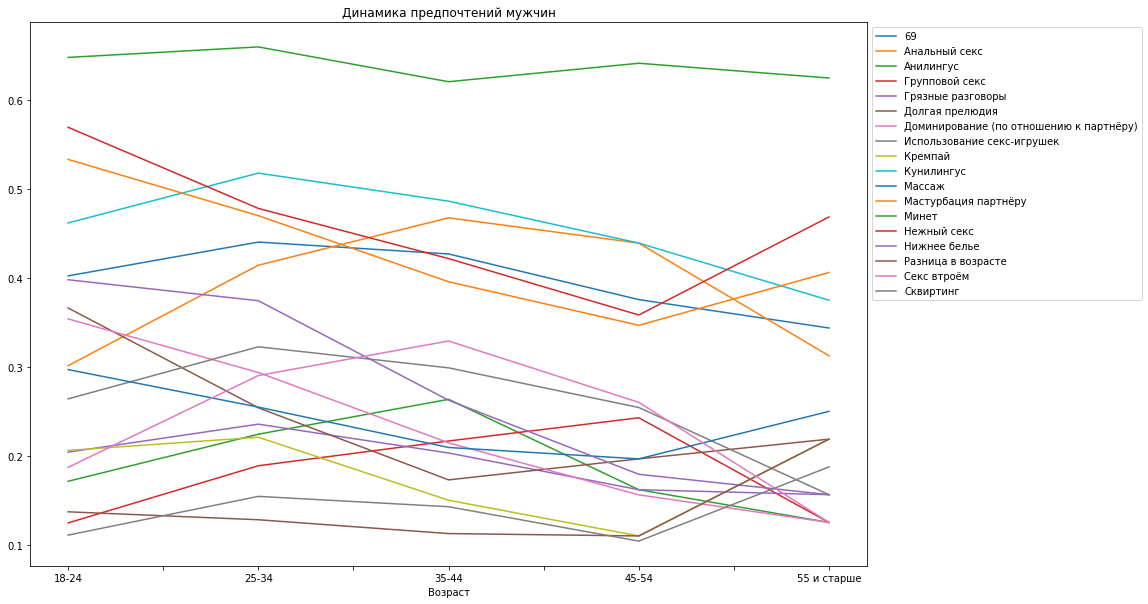

In [39]:
_ = prefs_stats[prefs_stats>0.1].loc["Мужской"].dropna(axis=1)\
.plot(figsize=[15, 10], title = "Динамика предпочтений мужчин")
plt.legend(bbox_to_anchor = (1,1))

### Женщины

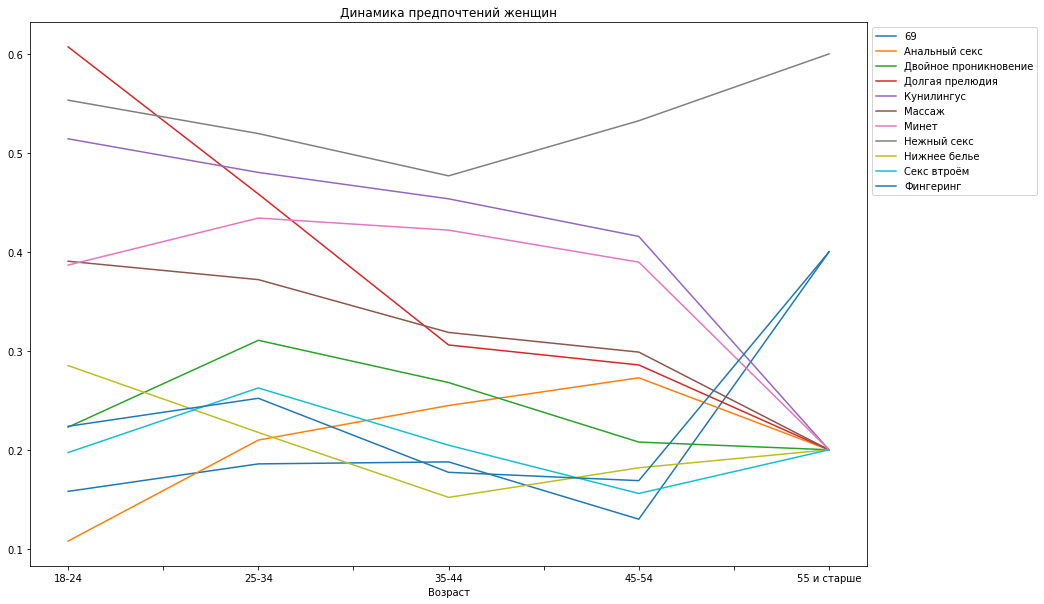

In [40]:
_ = prefs_stats[prefs_stats>0.1].loc["Женский"].dropna(axis=1)\
.plot(figsize=[15, 10], title = "Динамика предпочтений женщин")
plt.legend(bbox_to_anchor = (1,1))

## Зависимость числа предпочтений и практик от возраста

In [41]:
data["prefs_count"] = data["prefs_array"].apply(len)
data["practices_count"] = data["practices_array"].apply(len)

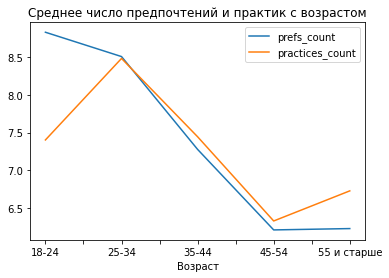

In [42]:
_ = data.groupby("Возраст")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot(title = "Среднее число предпочтений и практик с возрастом")

#### Женщины

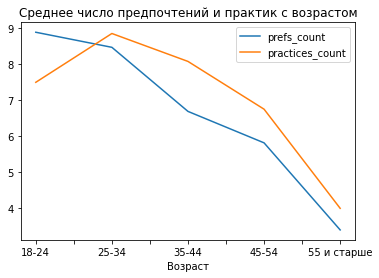

In [43]:
_ = data.loc[data["Пол"]=="Женский"]\
.groupby("Возраст")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot(title = "Среднее число предпочтений и практик с возрастом")

У женщин с возрастом число фантазий и практик уменьшается

### Мужчины

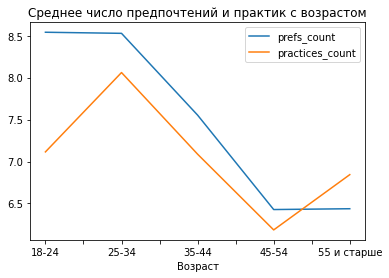

In [44]:
_ = data.loc[data["Пол"]=="Мужской"]\
.groupby("Возраст")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot(title = "Среднее число предпочтений и практик с возрастом")

У мужчин с возрастом число фантазий и практик уменьшается

## Зависимость числа предпочтений и практик от частоты

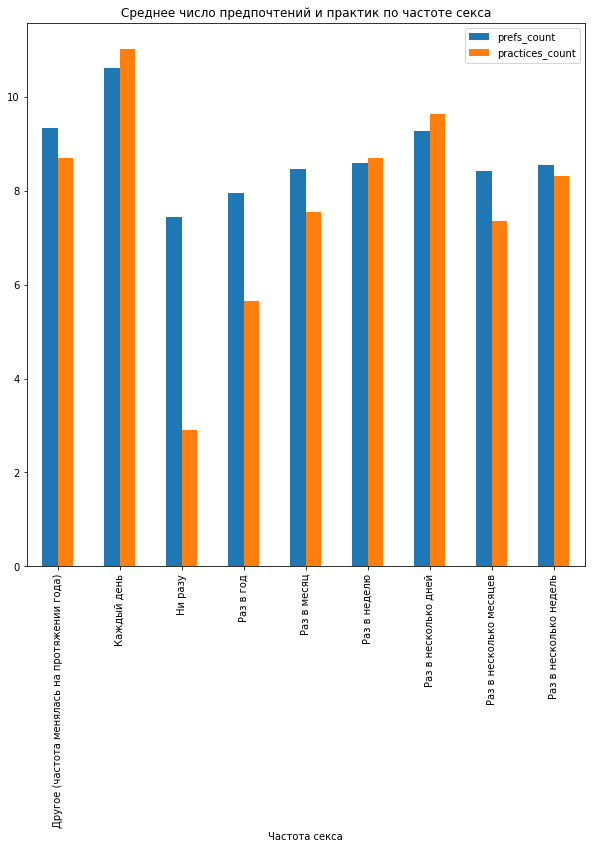

In [45]:
data\
.groupby("Частота секса")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot( kind="bar", figsize=[10,10],
    title = "Среднее число предпочтений и практик по частоте секса")

### Женщины

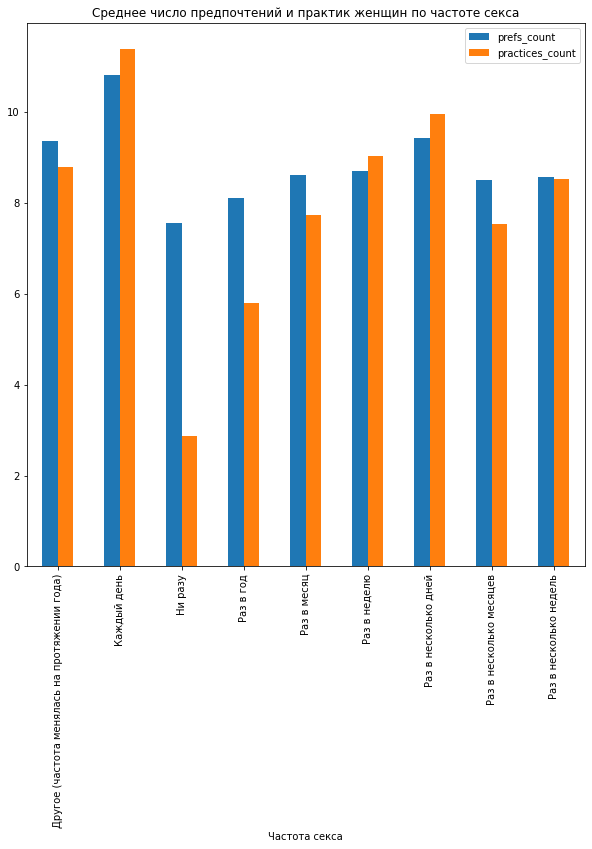

In [46]:
data.loc[data["Пол"]=="Женский"]\
.groupby("Частота секса")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot( kind="bar", figsize=[10,10],
    title = "Среднее число предпочтений и практик женщин по частоте секса")

### Мужчина

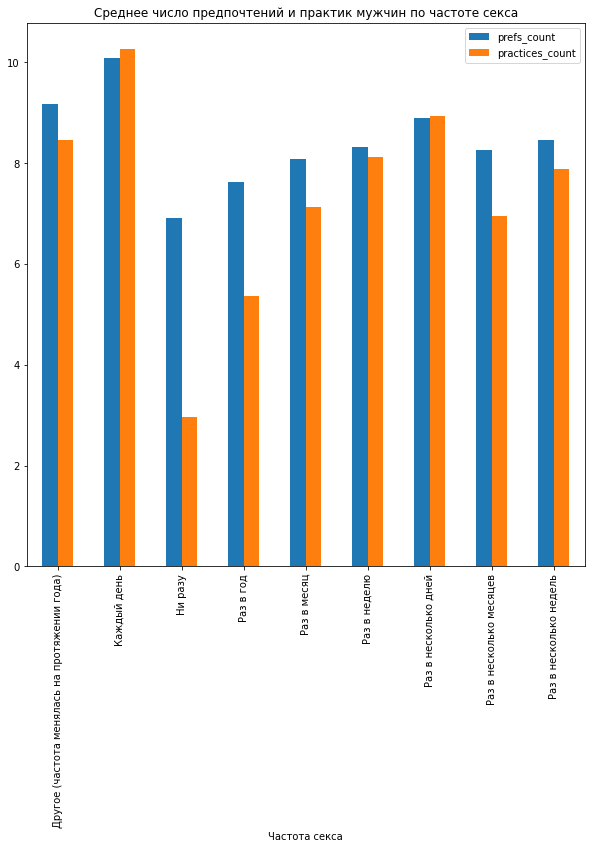

In [47]:
data.loc[data["Пол"]=="Мужской"]\
.groupby("Частота секса")\
.agg({"prefs_count":"mean", "practices_count":"mean"})\
.plot( kind="bar", figsize=[10,10],
    title = "Среднее число предпочтений и практик мужчин по частоте секса")

## Зависимость популярности практик от возраста

In [48]:
mlb = MultiLabelBinarizer()
pracs_matrix = pd.DataFrame(data = mlb.fit_transform(data["practices_array"]), columns = mlb.classes_)
pracs = pd.concat([data, pracs_matrix], axis=1)

pracs_stats = prefs.groupby(["Пол", "Возраст"])[ mlb.classes_].mean()

### Мужчины

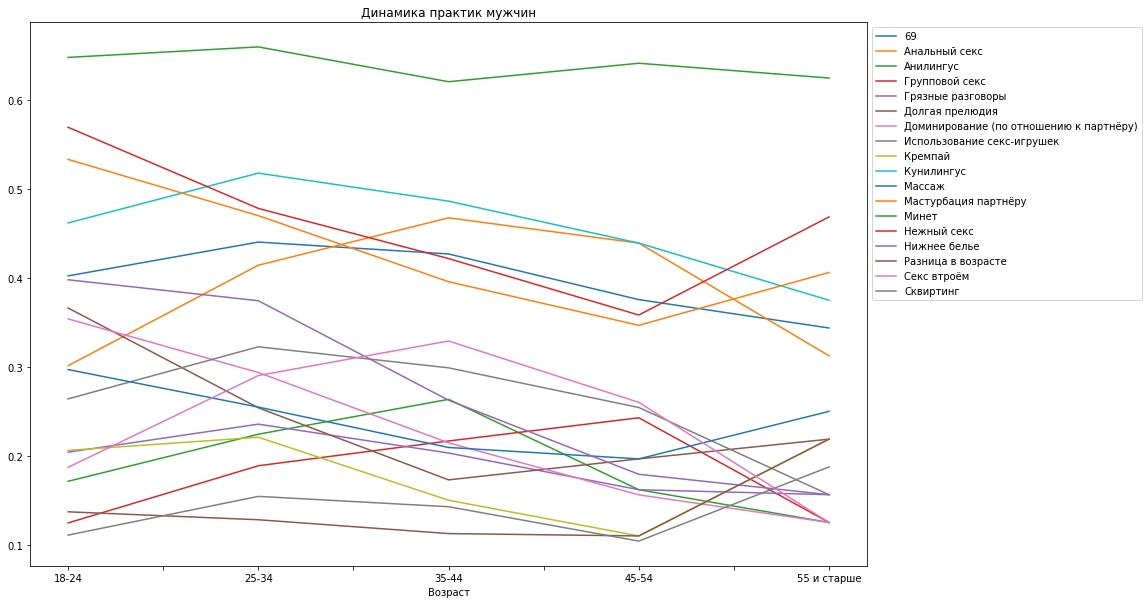

In [49]:
_ = pracs_stats[pracs_stats>0.1].loc["Мужской"].dropna(axis=1)\
.plot(figsize=[15, 10], title = "Динамика практик мужчин")
plt.legend(bbox_to_anchor = (1,1))

### Женщины

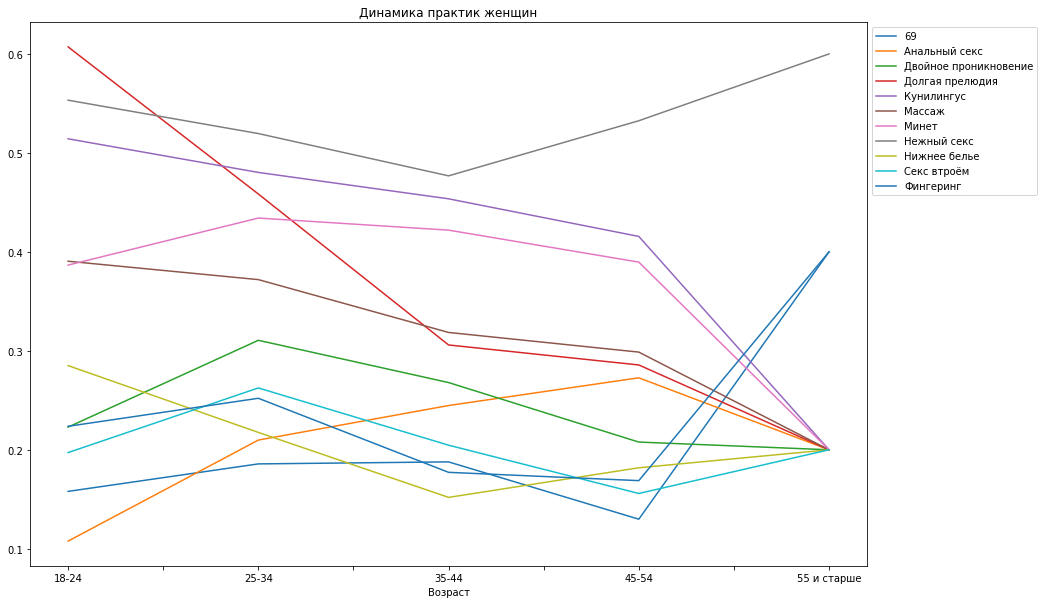

In [50]:
_ = pracs_stats[pracs_stats>0.1].loc["Женский"].dropna(axis=1)\
.plot(figsize=[15, 10], title = "Динамика практик женщин")
plt.legend(bbox_to_anchor = (1,1))

# Влияние нереализованных желаний на оценку реализации сексуальных предпочтений
Предскажем оценку реализации сексуальных предпочтений от списка нереализованных желаний - таким образом выявим наиболее критические для удовлетворения фантазии

In [51]:
def model(target_name, features_in, dataset, ascending=False):
  y = dataset[target_name]
  mlb = MultiLabelBinarizer()
  X = pd.DataFrame(mlb.fit_transform(dataset[features_in]), columns = mlb.classes_)

  data_for_model = pd.concat([X, y], axis=1).dropna()

  y = data_for_model[target_name]
  X = data_for_model.drop([target_name], axis=1)

  model_fitted = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
  summary = model_fitted.summary()

  model_result = pd.DataFrame(summary.tables[1].data[1:], columns = summary.tables[1].data[0])
  model_result["coef"] = model_result["coef"].astype(float) 
  model_result["coef_abs"] = abs(model_result["coef"])

  return model_result.sort_values("coef_abs", ascending = ascending)

## Женщины

In [52]:
women_data = data.loc[data["Пол"]=="Женский"]

women = model(target_name = "Оценка реализации сексуальных предпочтений", features_in = "prefs_but_not_practice", 
      dataset=women_data)
women[:20]

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,3.1255,0.015,206.727,0.000,3.096,3.155,3.1255
3,nan,0.2956,0.276,1.073,0.283,-0.245,0.836,0.2956
4,Анальный секс,0.1459,0.045,3.259,0.001,0.058,0.234,0.1459
15,Иное,0.1176,0.086,1.371,0.170,-0.051,0.286,0.1176
35,Сквиртинг,-0.1048,0.050,-2.099,0.036,-0.203,-0.007,0.1048
23,Минет,0.0803,0.043,1.852,0.064,-0.005,0.165,0.0803
14,Золотой дождь,-0.0746,0.090,-0.830,0.406,-0.251,0.102,0.0746
6,БДСМ,-0.0718,0.026,-2.720,0.007,-0.124,-0.020,0.0718
38,Фингеринг,-0.0717,0.035,-2.066,0.039,-0.140,-0.004,0.0717
20,Латекс,0.0708,0.057,1.252,0.210,-0.040,0.182,0.0708


Нереализованная мечта об анальном сексе (положительный коэффициент) только улучшате субъективную оценку реализации сексуальный предпочтений. Возможно, этой мечте лучше оставаться мечтой.

Тем временем, нереализованное желание испытать сквирт (отрицательный коэф) ухудшает оценку реализации предпочтений, поэтому её лучше воплотить в жизнь



## Мужчины

In [61]:
men_data = data.loc[data["Пол"]=="Мужской"]

men = model(target_name = "Оценка реализации сексуальных предпочтений", features_in = "prefs_but_not_practice", 
      dataset=men_data)
men[:20]

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,3.2904,0.034,97.228,0.000,3.224,3.357,3.2904
15,Иное,0.2856,0.195,1.465,0.143,-0.097,0.668,0.2856
3,nan,0.2096,0.475,0.441,0.659,-0.722,1.141,0.2096
7,Вуайеризм,-0.1968,0.339,-0.580,0.562,-0.862,0.469,0.1968
18,Куколд,-0.1514,0.132,-1.149,0.251,-0.410,0.107,0.1514
29,Порка,0.1473,0.099,1.490,0.136,-0.047,0.341,0.1473
5,Анилингус,0.1353,0.102,1.327,0.185,-0.065,0.335,0.1353
32,Свингеринг,0.1331,0.125,1.068,0.285,-0.111,0.377,0.1331
10,Двойное проникновение,-0.1322,0.074,-1.796,0.073,-0.277,0.012,0.1322
11,Долгая прелюдия,0.1266,0.080,1.582,0.114,-0.030,0.284,0.1266


Нереализованные фантазии о различных нестандартных практиках (Иное, положительный коэффициент) повышают субъективную оценку реализации сексуальных предпочтений, вероятно, совсем необычные желаняи мужчинам лучше не реализовывать

Желание же подглядывать (Вуайеризм, отрицательный коэффициент) лучше реализовать, это должно повысить удовлетворённость реализованностью своих фантазий

# Влияние реализуемых предпочтений на оценку сексуальной жизни

In [56]:
def model(target_name, features_in, dataset, ascending=False):
  y = dataset[target_name]
  mlb = MultiLabelBinarizer()
  X = pd.DataFrame(mlb.fit_transform(dataset[features_in]), columns = mlb.classes_)

  data_for_model = pd.concat([X, y], axis=1).dropna()

  y = data_for_model[target_name]
  X = data_for_model.drop([target_name], axis=1)

  model_fitted = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
  summary = model_fitted.summary()

  model_result = pd.DataFrame(summary.tables[1].data[1:], columns = summary.tables[1].data[0])
  model_result["coef"] = model_result["coef"].astype(float) 
  model_result["coef_abs"] = abs(model_result["coef"])

  return model_result.sort_values("coef_abs", ascending = ascending)

## Женщины

In [57]:
women_data = data.loc[data["Пол"]=="Женский"]

women = model(target_name = "Оценка сексуальной жизни", features_in = "pref_and_practice", 
      dataset=women_data)
women.head(20)

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,6.3668,0.034,188.939,0.000,6.301,6.433,6.3668
20,Латекс,0.5240,0.355,1.478,0.139,-0.171,1.219,0.5240
7,Вуайеризм,0.3262,0.574,0.568,0.570,-0.799,1.452,0.3262
8,Групповой секс,0.2028,0.204,0.993,0.321,-0.198,0.603,0.2028
5,Анилингус,0.1873,0.109,1.711,0.087,-0.027,0.402,0.1873
36,Страпон,-0.1800,0.133,-1.358,0.174,-0.440,0.080,0.1800
14,Золотой дождь,0.1785,0.287,0.622,0.534,-0.384,0.741,0.1785
40,Фут-фетиш,-0.1775,0.130,-1.370,0.171,-0.431,0.076,0.1775
32,Свингеринг,0.1651,0.527,0.313,0.754,-0.869,1.199,0.1651
18,Куколд,0.1618,0.412,0.393,0.695,-0.646,0.969,0.1618


На оценку сексуальной жизни женщиной положительно сказывается реализация фантазий о латексе, вуайеризме и групповом сексе. 

Реализация же фантазий о страпоне, фут-фетише и грязных разговорах скорее понизит оценку сексуальной жизни.

## Мужчины

In [58]:
men_data = data.loc[data["Пол"]=="Мужской"]

men = model(target_name = "Оценка сексуальной жизни", features_in = "pref_and_practice", 
      dataset=men_data)
men.head(20)

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,6.1429,0.087,70.315,0.000,5.972,6.314,6.1429
7,Вуайеризм,-2.2329,2.575,-0.867,0.386,-7.283,2.817,2.2329
15,Иное,-1.0290,0.863,-1.192,0.233,-2.722,0.664,1.0290
20,Латекс,0.9615,0.806,1.193,0.233,-0.619,2.542,0.9615
39,Фистинг,0.5798,0.342,1.694,0.090,-0.091,1.251,0.5798
2,ASMR,-0.5655,0.398,-1.421,0.155,-1.346,0.215,0.5655
18,Куколд,-0.4018,0.556,-0.722,0.470,-1.492,0.689,0.4018
33,Связывание,0.3570,0.186,1.915,0.056,-0.009,0.723,0.3570
31,Ролевые игры,-0.3426,0.268,-1.277,0.202,-0.868,0.183,0.3426
40,Фут-фетиш,0.3041,0.198,1.540,0.124,-0.083,0.691,0.3041


Мужчинам противопоказано реализовывать мечты о подглядывании (коэфффициент -2.2) и совсем необычных практиках (-1.02)

Но те, кто попробовли латекс(0.96) и фистинг(0.58) в среднем более удовлетворены своей сексуальной жизнью 

## Совместно

In [59]:
together_prefs_on_q = pd.merge(women[["", "coef", "coef_abs"]], men[["", "coef", "coef_abs"]], left_on="", right_on="", 
                               suffixes=("_women", "_men"))\
                      .set_index("")\
                      .drop("const")

together_prefs_on_q["coef_abs_total"] = together_prefs_on_q["coef_abs_women"] + together_prefs_on_q["coef_abs_men"]
together_prefs_on_q = together_prefs_on_q.sort_values("coef_abs_total")

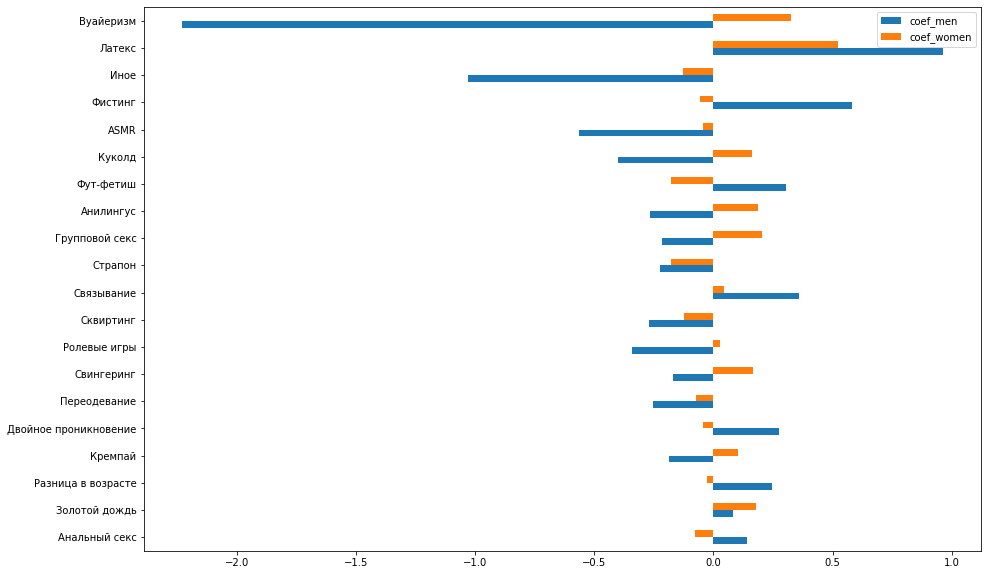

In [60]:
together_prefs_on_q[-20:][["coef_men", "coef_women"]].plot(kind="barh", figsize=[15,10])

# Влияние практик на оценку сексуальной жизни

## Мужчины

In [67]:
men_data = data.loc[data["Пол"]=="Мужской"]

men = model(target_name = "Оценка сексуальной жизни", features_in = "practices_array", 
      dataset=men_data)
men.head(20)

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,6.1020,0.126,48.323,0.000,5.854,6.350,6.1020
7,Вуайеризм,-2.0547,2.572,-0.799,0.425,-7.099,2.989,2.0547
14,Золотой дождь,0.5118,0.323,1.584,0.113,-0.122,1.145,0.5118
20,Латекс,0.4901,0.595,0.824,0.410,-0.676,1.656,0.4901
27,Переодевание,-0.4567,0.253,-1.802,0.072,-0.954,0.040,0.4567
2,ASMR,-0.3461,0.348,-0.994,0.320,-1.029,0.336,0.3461
33,Связывание,0.3329,0.157,2.122,0.034,0.025,0.641,0.3329
35,Сквиртинг,-0.3019,0.214,-1.410,0.159,-0.722,0.118,0.3019
39,Фистинг,0.2985,0.237,1.258,0.209,-0.167,0.764,0.2985
15,Иное,-0.2874,0.394,-0.730,0.466,-1.060,0.485,0.2874


## Женщины

In [69]:
women_data = data.loc[data["Пол"]=="Женский"]

women = model(target_name = "Оценка сексуальной жизни", features_in = "practices_array", 
      dataset=women_data)
women.head(20)

,,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,const,6.3163,0.051,124.363,0.000,6.217,6.416,6.3163
18,Куколд,-0.2604,0.266,-0.980,0.327,-0.781,0.260,0.2604
32,Свингеринг,0.2237,0.305,0.734,0.463,-0.374,0.821,0.2237
3,nan,0.1800,0.087,2.060,0.039,0.009,0.351,0.1800
8,Групповой секс,0.1616,0.159,1.014,0.311,-0.151,0.474,0.1616
7,Вуайеризм,0.1503,0.440,0.341,0.733,-0.713,1.014,0.1503
17,Кремпай,0.1424,0.103,1.384,0.166,-0.059,0.344,0.1424
36,Страпон,-0.1406,0.102,-1.381,0.167,-0.340,0.059,0.1406
5,Анилингус,0.1256,0.076,1.646,0.100,-0.024,0.275,0.1256
38,Фингеринг,-0.1153,0.051,-2.278,0.023,-0.215,-0.016,0.1153


На оценку качества сексуальной жизни женщин положительно влияют свингеринг, групповой секс и подглядывание.

Негативное же влияние оказывают куколд, страпон и свингеринг.

Интересный вывод: женщинам секс втроём скорее не нравится, а вот групповой подходит отлично.